In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import numpy as np
# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [2]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

Client Scheduler: tcp://127.0.0.1:49868 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 34.36 GB


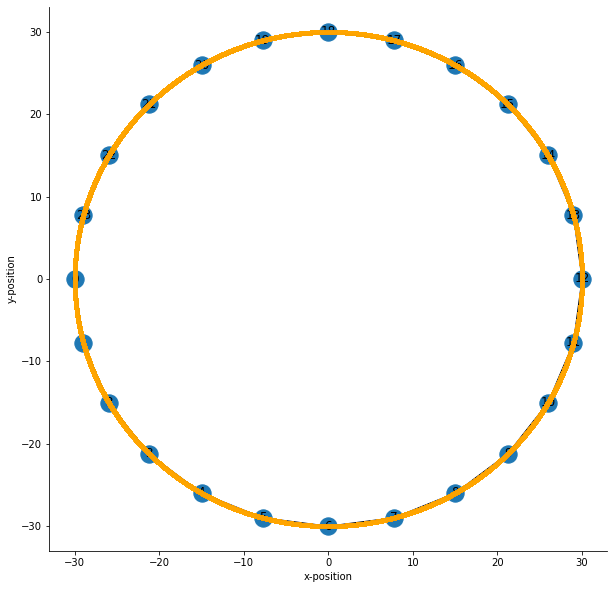

In [3]:
from track_linearization import make_track_graph, plot_track_graph
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

angle = np.linspace(-np.pi, np.pi, num=24, endpoint=False)
radius = 30

node_positions = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

node_ids = np.arange(node_positions.shape[0])
edges = np.stack((node_ids, np.roll(node_ids, shift=1)), axis=1)

track_graph = make_track_graph(node_positions, edges)

position_angles = np.linspace(-np.pi, 31 * np.pi, num=360_000, endpoint=False)
position = np.stack((radius * np.cos(position_angles), radius * np.sin(position_angles)), axis=1)
# position += multivariate_normal(mean=0, cov=.005).rvs(position.shape)

fig, ax = plt.subplots(figsize=(10, 10))
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.scatter(position[:, 0], position[:, 1], alpha=0.25, s=10, zorder=11, color="orange")

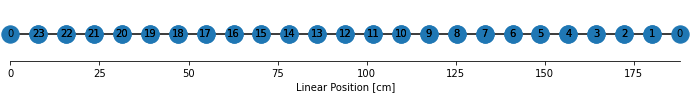

In [4]:
from track_linearization import plot_graph_as_1D

edge_spacing = 0
n_nodes = len(track_graph.nodes)
edge_order = np.stack((np.roll(np.arange(n_nodes-1, -1, -1), 1),
                       np.arange(n_nodes-1, -1, -1)), axis=1)

fig, ax = plt.subplots(figsize=(n_nodes // 2, 1))
plot_graph_as_1D(track_graph,
                 edge_spacing=edge_spacing,
                 edge_order=edge_order,
                 ax=ax)

In [5]:
from track_linearization import get_linearized_position

position_df = get_linearized_position(position, track_graph, edge_order=edge_order, edge_spacing=edge_spacing, use_HMM=False)
position_df

,linear_position,track_segment_id,projected_x_position,projected_y_position
0,0.000000,0,-30.000000,-3.673940e-15
1,187.949411,1,-29.998916,-8.235002e-03
2,187.941104,1,-29.997832,-1.647031e-02
3,187.932798,1,-29.996747,-2.470591e-02
4,187.924491,1,-29.995663,-3.294182e-02
...,...,...,...,...
359995,0.041533,0,-29.994579,4.117803e-02
359996,0.033226,0,-29.995663,3.294182e-02
359997,0.024919,0,-29.996747,2.470591e-02
359998,0.016612,0,-29.997832,1.647031e-02


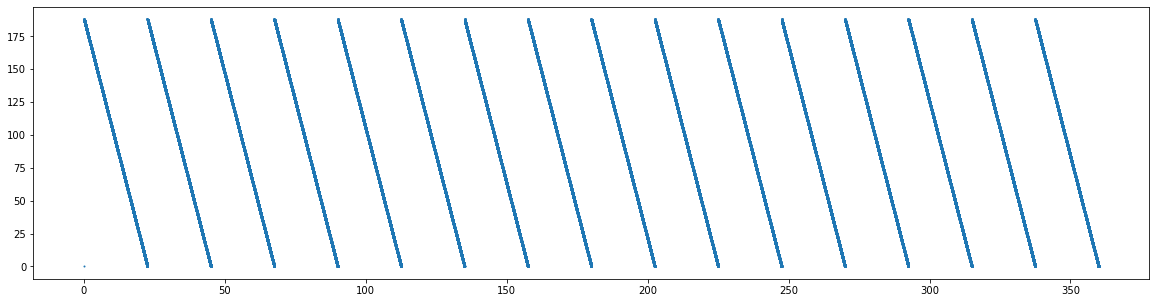

In [6]:
plt.figure(figsize=(20, 5))

sampling_frequency = 1000
time = np.arange(position_df.linear_position.size) / sampling_frequency
plt.scatter(time, position_df.linear_position, clip_on=False, s=1)

In [7]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field

angle = np.linspace(-np.pi, np.pi, num=24, endpoint=False)

place_field_centers = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

spikes = np.stack([simulate_neuron_with_place_field(center, position, sampling_frequency=sampling_frequency, variance=6.0**2)
                   for center in place_field_centers], axis=1)
spikes.shape

(360000, 24)

In [8]:
spikes.sum(axis=0)

array([478., 473., 417., 427., 432., 428., 438., 448., 468., 463., 444.,
       427., 448., 426., 387., 444., 451., 465., 421., 442., 413., 404.,
       428., 447.])

(-32.99999877178257, 32.999999941513465, -32.9999982454037, 33.000000467892335)

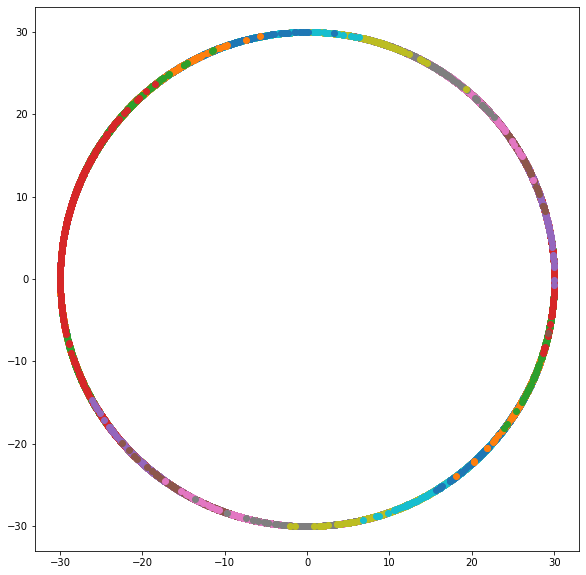

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
for spike in spikes.T:
    spike_ind = np.nonzero(spike)[0]
    ax.scatter(position[spike_ind, 0], position[spike_ind, 1])
    
ax.axis("square")

In [10]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(position, sampling_frequency)
movement_var = np.mean(np.diag(movement_var))
movement_var = 0.25
place_bin_size = 0.5

decoder = SortedSpikesDecoder(
    replay_speed=1,
    movement_var=0.25,
    place_bin_size=place_bin_size)

decoder

SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=0.25, place_bin_size=0.5, position_range=None,
                    replay_speed=1, spike_model_penalty=10.0,
                    transition_type='random_walk')

In [11]:
decoder.fit(position_df.linear_position,
            spikes,
            track_graph=track_graph,
            edge_order=edge_order,
            edge_spacing=edge_spacing)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=0.25, place_bin_size=0.5, position_range=None,
                    replay_speed=1, spike_model_penalty=10.0,
                    transition_type='random_walk')

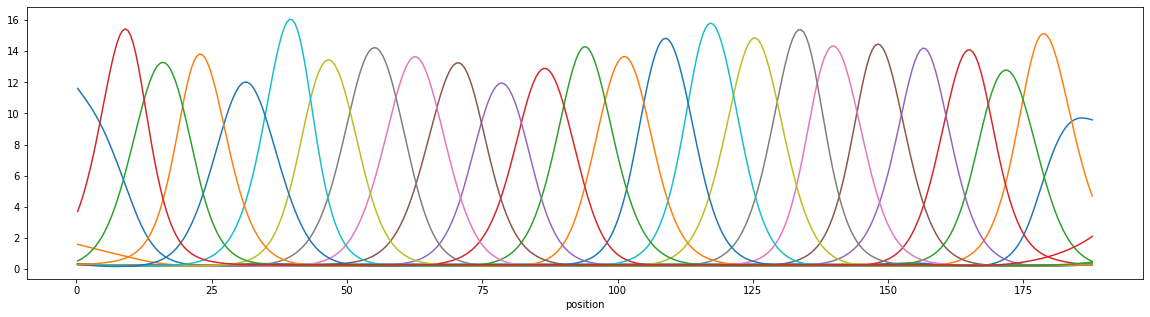

In [12]:
fig, ax = plt.subplots(figsize=(20, 5))
(decoder.place_fields_ * sampling_frequency).plot(x="position", hue="neuron", add_legend=False, ax=ax);

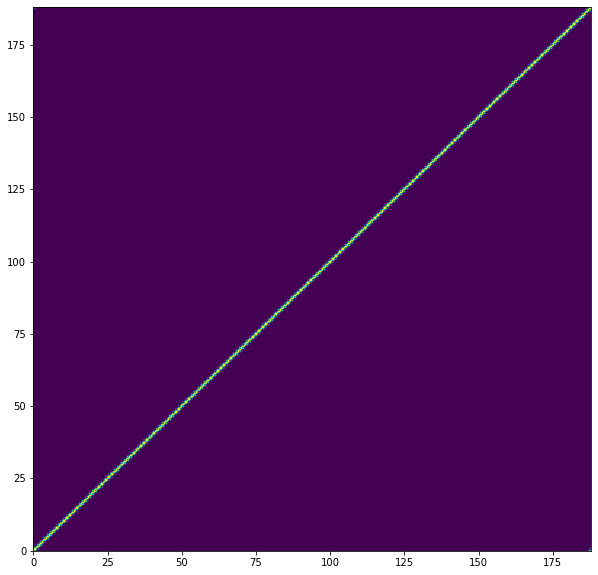

In [13]:
plt.figure(figsize=(10, 10))
bin1, bin2 = np.meshgrid(decoder.place_bin_edges_, decoder.place_bin_edges_)
plt.pcolormesh(bin1, bin2, decoder.state_transition_.T, vmin=0.0)

In [14]:
results = decoder.predict(spikes, time=time)

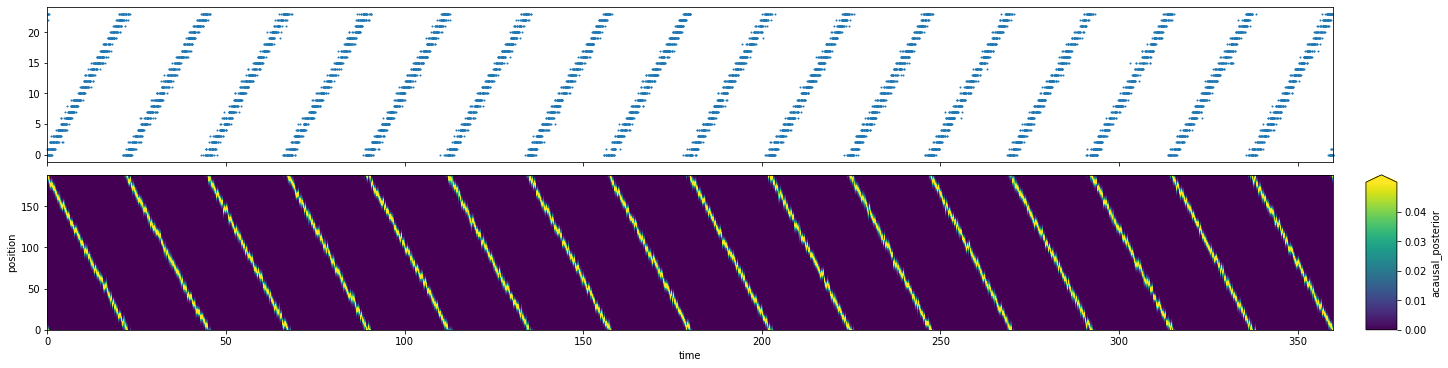

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True, constrained_layout=True)

spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[0].scatter(time[spike_time_ind], neuron_ind, clip_on=False, s=1)

results.acausal_posterior.plot(x="time", y="position", vmin=0.0, ax=axes[1], robust=True)
# axes[1].scatter(time, position_df.linear_position, color="magenta", s=1)

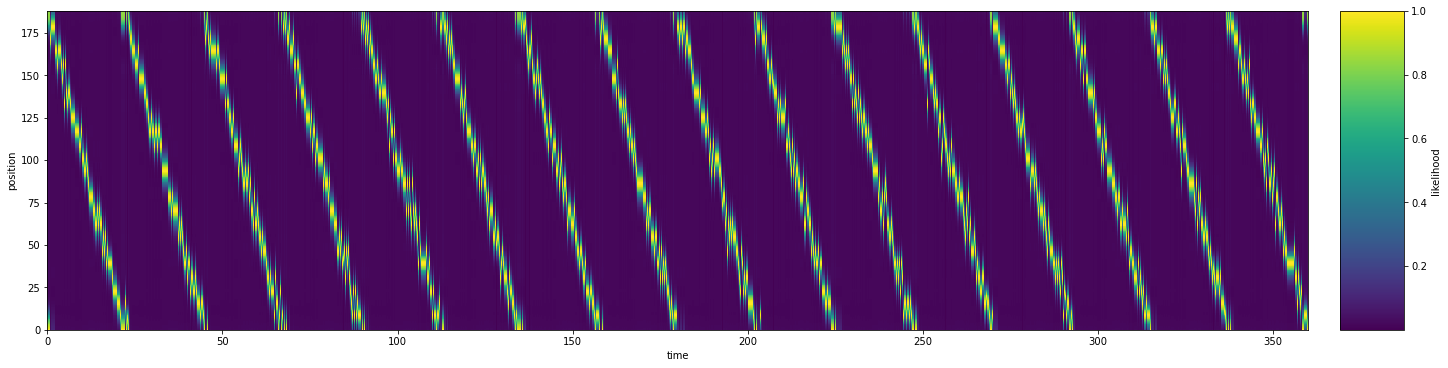

In [16]:
plt.subplots(1, 1, figsize=(20, 5), sharex=True, constrained_layout=True)
results.likelihood.isel(time=spike_time_ind).plot(x="time", y="position")

# No Track Graph

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


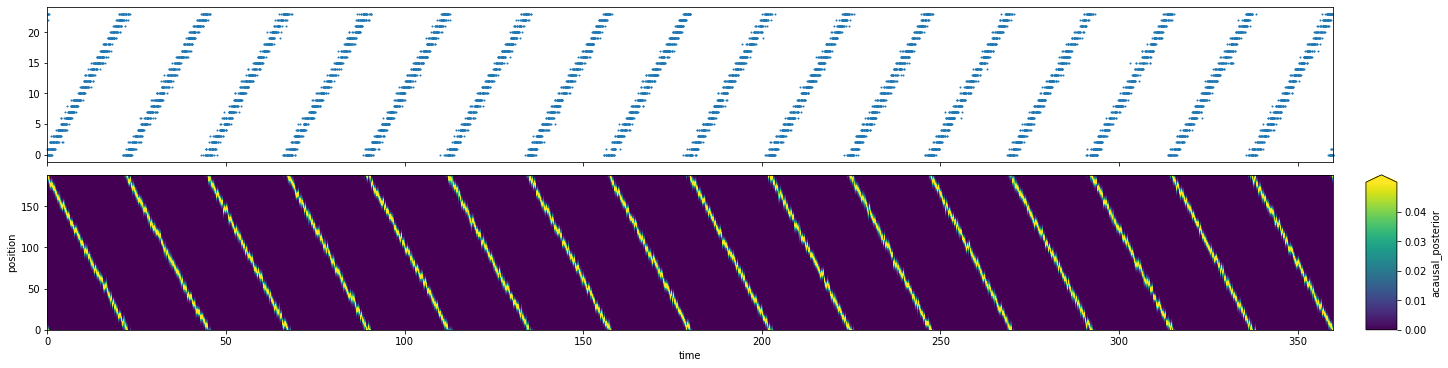

In [17]:
decoder2 = SortedSpikesDecoder(
    replay_speed=1,
    movement_var=movement_var,
    place_bin_size=place_bin_size)

decoder2.fit(position_df.linear_position,
             spikes)

results2 = decoder.predict(spikes, time=time)

fig, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True, constrained_layout=True)

spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[0].scatter(time[spike_time_ind], neuron_ind, clip_on=False, s=1)

results2.acausal_posterior.plot(x="time", y="position", vmin=0.0, ax=axes[1], robust=True)